<a href="https://colab.research.google.com/github/alperenndemirbas/YOLOv8-Autonomous-Driving/blob/main/YOLOv8_Autonomous_Driving_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Install Dependencies ---
# Installs required ML libraries and Kaggle CLI.
!pip install tensorflow==2.15.0 keras==2.15.0 -q
!pip install keras-cv==0.8.2 -q
!pip install kaggle -q

print("Installation complete. Restart the runtime to apply changes.")


ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 34.8 MB/s eta 0:00:00
Installation complete. Restart the runtime to apply changes.


In [ ]:
# --- Dataset Setup ---
# Downloads the dataset via Kaggle if it's not already available.

import os
from google.colab import files

# Download dataset only if missing
if not os.path.exists('self-driving-cars'):
    print("Please upload your kaggle.json API key:")
    files.upload()

    # Configure Kaggle credentials
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    # Download and extract dataset
    !kaggle datasets download -d alincijov/self-driving-cars
    !unzip -q self-driving-cars.zip -d self-driving-cars

    print("Dataset downloaded and extracted.")

Please upload your kaggle.json API key:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/alincijov/self-driving-cars
License(s): CC0-1.0
 96% 852M/892M [00:00<00:00, 1.44GB/s]
100% 892M/892M [00:00<00:00, 1.54GB/s]
Dataset downloaded and extracted.


In [ ]:
# --- 3. DATA PIPELINE & MODEL TRAINING SETUP ---
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_cv
from tensorflow import keras

# --- CONFIGURATION ---
DATA_DIR = 'self-driving-cars/'
IMAGES_DIR = os.path.join(DATA_DIR, 'images')
TRAIN_LABELS = os.path.join(DATA_DIR, 'labels_train.csv')
VAL_LABELS = os.path.join(DATA_DIR, 'labels_val.csv')

BATCH_SIZE = 8
IMAGE_SIZE = (640, 640)
BBOX_FORMAT = "xyxy"
# Class mapping for PASCAL VOC / COCO style detection
CLASS_MAPPING = {0: 'car', 1: 'truck', 2: 'pedestrian', 3: 'bicyclist', 4: 'light'}
NUM_CLASSES = len(CLASS_MAPPING)

# --- DATA PARSING ---
def parse_annotation(group):
    """
    Parses a group of dataframe rows belonging to a single image frame.
    Returns a dictionary compatible with tf.data.
    """
    image_path = os.path.join(IMAGES_DIR, group['frame'].iloc[0])
    if not os.path.exists(image_path):
        return None

    # Shift class IDs to start from 0
    class_ids = (group['class_id'] - 1).tolist()
    boxes = group[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()

    return {
        'image_path': image_path,
        'boxes': boxes,
        'classes': class_ids
    }

# Load and group CSV data
train_df = pd.read_csv(TRAIN_LABELS)
val_df = pd.read_csv(VAL_LABELS)

train_data = [parse_annotation(g) for _, g in train_df.groupby('frame')]
val_data = [parse_annotation(g) for _, g in val_df.groupby('frame')]

# Filter None values (missing images)
train_data = [x for x in train_data if x is not None]
val_data = [x for x in val_data if x is not None]

# Calculate global maximum boxes per image for padding
max_boxes_train = max((len(x['boxes']) for x in train_data), default=0)
max_boxes_val = max((len(x['boxes']) for x in val_data), default=0)
MAX_BOXES = max(max_boxes_train, max_boxes_val, 1)

print(f"Data Loaded: {len(train_data)} train, {len(val_data)} val images.")
print(f"Max boxes per image: {MAX_BOXES}")

# --- TF.DATA PIPELINE UTILITIES ---

def load_image(data_entry):
    """Loads jpeg image from disk and decodes it."""
    img = tf.io.read_file(data_entry['images'])
    img = tf.image.decode_jpeg(img, channels=3)
    return {'images': img, 'bounding_boxes': data_entry['bounding_boxes']}

def pad_to_fixed_size(entry):
    """Pads boxes and classes to MAX_BOXES using -1 as the padding value."""
    boxes = entry['boxes']
    classes = entry['classes']
    pad_len = MAX_BOXES - len(boxes)

    padded_boxes = boxes + [[-1.0, -1.0, -1.0, -1.0]] * pad_len
    padded_classes = classes + [-1] * pad_len

    return {
        'images': entry['image_path'],
        'bounding_boxes': {
            'boxes': tf.constant(padded_boxes, dtype=tf.float32),
            'classes': tf.constant(padded_classes, dtype=tf.int64)
        }
    }

def create_dataset(data_list):
    """Creates a tf.data.Dataset from a list of dictionaries."""
    def generator():
        for item in data_list:
            yield pad_to_fixed_size(item)

    return tf.data.Dataset.from_generator(
        generator,
        output_signature={
            'images': tf.TensorSpec(shape=(), dtype=tf.string),
            'bounding_boxes': {
                'boxes': tf.TensorSpec(shape=(MAX_BOXES, 4), dtype=tf.float32),
                'classes': tf.TensorSpec(shape=(MAX_BOXES,), dtype=tf.int64)
            }
        }
    )

# --- PIPELINE CONSTRUCTION ---

# Augmentation layers
augmenter = keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format=BBOX_FORMAT)
resizer = keras_cv.layers.JitteredResize(
    target_size=IMAGE_SIZE, scale_factor=(0.75, 1.3), bounding_box_format=BBOX_FORMAT
)

# Build Datasets
train_ds = create_dataset(train_data)
val_ds = create_dataset(val_data)

# Map loading functions
train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

# Apply Augmentation & Batching
# Note: We use .padded_batch() because augmentation layers may strip padding.
# Padding values must match the dtype of the output (float32 for resized classes).
pad_shapes = {
    'images': [IMAGE_SIZE[0], IMAGE_SIZE[1], 3],
    'bounding_boxes': {
        'boxes': [MAX_BOXES, 4],
        'classes': [MAX_BOXES]
    }
}
pad_values = {
    'images': tf.constant(0.0, dtype=tf.float32),
    'bounding_boxes': {
        'boxes': tf.constant(-1.0, dtype=tf.float32),
        'classes': tf.constant(-1.0, dtype=tf.float32)
    }
}

train_ds = (train_ds
    .shuffle(BATCH_SIZE * 4)
    .map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
    .map(resizer, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(BATCH_SIZE, padded_shapes=pad_shapes, padding_values=pad_values, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (val_ds
    .map(resizer, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(BATCH_SIZE, padded_shapes=pad_shapes, padding_values=pad_values, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

print("Data Pipelines are ready.")

# --- MODEL INITIALIZATION ---
print("Initializing YOLOv8 Model (Backbone: COCO)...")
model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_backbone_coco",
    num_classes=NUM_CLASSES,
    bounding_box_format=BBOX_FORMAT
)

# Compile with Adam optimizer and standard YOLO losses
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    classification_loss="binary_crossentropy",
    box_loss="ciou"
)

print("Model Compiled successfully.")

Data Loaded: 18000 train, 4241 val images.
Max boxes per image: 31
Data Pipelines are ready.
Initializing YOLOv8 Model (Backbone: COCO)...


100%|██████████| 646/646 [00:00<00:00, 1.24MB/s]


100%|██████████| 45.6M/45.6M [00:03<00:00, 12.8MB/s]


Model Compiled successfully.


In [ ]:
import tensorflow as tf
from google.colab import drive

# --- Mount Google Drive for saving the final model ---
drive.mount("/content/drive")

# --- Training Configuration ---
EPOCHS = 15

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# --- Model Training ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

# --- Save Trained Model ---
model_save_path = "/content/drive/MyDrive/yolov8_model"
model.save(model_save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model eğitimi başlıyor...
Eğitim veri seti: train_ds
Doğrulama veri seti: val_ds
Epoch sayısı: 15
Epoch 1/15
   2250/Unknown 1427s 589ms/step - box_loss: 3.1222 - class_loss: 337.9571 - loss: 341.0793

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1525s 632ms/step - box_loss: 3.1220 - class_loss: 337.8605 - loss: 340.9824 - val_box_loss: 2.1132 - val_class_loss: 19.9816 - val_loss: 22.0949
Epoch 2/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - box_loss: 2.0539 - class_loss: 11.7285 - loss: 13.7824

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1423s 632ms/step - box_loss: 2.0538 - class_loss: 11.7264 - loss: 13.7803 - val_box_loss: 1.8249 - val_class_loss: 3.6044 - val_loss: 5.4293
Epoch 3/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - box_loss: 1.8426 - class_loss: 2.3279 - loss: 4.1705

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1424s 633ms/step - box_loss: 1.8425 - class_loss: 2.3276 - loss: 4.1701 - val_box_loss: 1.7354 - val_class_loss: 1.3973 - val_loss: 3.1327
Epoch 4/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - box_loss: 1.7423 - class_loss: 0.7315 - loss: 2.4738

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1425s 633ms/step - box_loss: 1.7422 - class_loss: 0.7315 - loss: 2.4737 - val_box_loss: 1.7120 - val_class_loss: 0.4476 - val_loss: 2.1596
Epoch 5/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - box_loss: 1.6934 - class_loss: 0.3506 - loss: 2.0440

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1426s 634ms/step - box_loss: 1.6934 - class_loss: 0.3506 - loss: 2.0439 - val_box_loss: 1.6837 - val_class_loss: 0.3548 - val_loss: 2.0385
Epoch 6/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1428s 634ms/step - box_loss: 1.6703 - class_loss: 0.2467 - loss: 1.9169 - val_box_loss: 1.6588 - val_class_loss: 0.2484 - val_loss: 1.9072
Epoch 7/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1427s 634ms/step - box_loss: 1.6385 - class_loss: 0.2128 - loss: 1.8513 - val_box_loss: 1.6156 - val_class_loss: 0.2273 - val_loss: 1.8429
Epoch 8/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1424s 633ms/step - box_loss: 1.5977 - class_loss: 0.1968 - loss: 1.7945 - val_box_loss: 1.6063 - val_class_loss: 0.2226 - val_loss: 1.8289
Epoch 9/15
 300/2250 ━━━━━━━━━━━━━━━━━━━━ 19:16 593ms/step - box_loss: 1.7856 - class_loss: 0.2190 - loss: 2.0046

In [ ]:
# --- 5. DOWNLOAD SAMPLE VIDEO ---
# We download a high-quality sample video from Pexels to test the model.
import os

VIDEO_URL = "https://videos.pexels.com/video-files/2103099/2103099-hd_1920_1080_30fps.mp4"
INPUT_VIDEO = "test_video.mp4"

# Remove existing file to ensure a fresh download
if os.path.exists(INPUT_VIDEO):
    os.remove(INPUT_VIDEO)

print("Downloading sample video...")
!wget -O {INPUT_VIDEO} -q {VIDEO_URL}

# Verify download integrity
if os.path.exists(INPUT_VIDEO) and os.path.getsize(INPUT_VIDEO) > 1000:
    print(f"Video downloaded successfully: {INPUT_VIDEO}")
else:
    print("Download failed. Please upload a video manually.")

In [ ]:
# --- 6. RUN INFERENCE ON VIDEO ---
import cv2
import numpy as np
import tensorflow as tf
import keras_cv

# --- CONFIGURATION ---
INPUT_VIDEO = "test_video.mp4"
OUTPUT_VIDEO = "final_inference_result.mp4"
# Path to the saved model (Ensure this matches the path in Cell 4)
MODEL_PATH = '/content/drive/MyDrive/yolov8_model_manuel_kayit.keras'

CONFIDENCE_THRESHOLD = 0.25  # Lower threshold for better detection recall
IMAGE_SIZE = (640, 640)

# Colors for visualization (BGR format)
COLORS = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]
CLASS_MAPPING = {0: 'Car', 1: 'Truck', 2: 'Pedestrian', 3: 'Cyclist', 4: 'Traffic Light'}

# --- LOAD MODEL ---
print("Loading model...")
model = tf.keras.models.load_model(
    MODEL_PATH,
    compile=False, # We only need inference, so compilation is skipped
    custom_objects={
        "YOLOV8Detector": keras_cv.models.YOLOV8Detector,
        "YOLOV8Backbone": keras_cv.models.YOLOV8Backbone
    }
)

# --- VIDEO SETUP ---
cap = cv2.VideoCapture(INPUT_VIDEO)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Initialize Video Writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (width, height))

print(f"Processing Video: {width}x{height} pixels, {total_frames} frames.")

frame_count = 0

# --- INFERENCE LOOP ---
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count % 50 == 0:
        print(f"Processing frame {frame_count}/{total_frames}...")

    # 1. PREPROCESSING
    # Convert BGR (OpenCV) to RGB (Model expectation)
    input_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Resize with padding to maintain aspect ratio (Crucial for accuracy)
    input_frame = tf.image.resize_with_pad(input_frame, IMAGE_SIZE[0], IMAGE_SIZE[1])

    # Cast to float32 and add batch dimension
    input_frame = tf.cast(input_frame, tf.float32)
    input_frame = tf.expand_dims(input_frame, axis=0)

    # 2. PREDICTION
    predictions = model.predict(input_frame, verbose=0)

    boxes = predictions['boxes'][0]
    classes = predictions['classes'][0]
    confidence = predictions['confidence'][0]

    # 3. COORDINATE RESCALING
    # Since we used resize_with_pad, we need to calculate the scale and offsets
    # to map the coordinates back to the original 1920x1080 frame.

    ratio_x = IMAGE_SIZE[0] / width
    ratio_y = IMAGE_SIZE[1] / height
    scale = min(ratio_x, ratio_y)

    # Calculate padding offsets
    offset_x = (IMAGE_SIZE[0] - width * scale) / 2
    offset_y = (IMAGE_SIZE[1] - height * scale) / 2

    # Filter invalid detections (-1 padding)
    valid_indices = np.where(classes != -1)[0]

    # 4. VISUALIZATION
    draw_frame = frame.copy()

    for i in valid_indices:
        score = float(confidence[i])

        if score > CONFIDENCE_THRESHOLD:
            box = boxes[i]

            # Map coordinates back to original image
            # Formula: (x_padded - offset) / scale
            x1 = int((box[0] - offset_x) / scale)
            y1 = int((box[1] - offset_y) / scale)
            x2 = int((box[2] - offset_x) / scale)
            y2 = int((box[3] - offset_y) / scale)

            class_id = int(classes[i])
            label_text = CLASS_MAPPING.get(class_id, 'Unknown')
            full_label = f"{label_text} {score:.2f}"

            color = COLORS[class_id % len(COLORS)]

            # Draw Box
            cv2.rectangle(draw_frame, (x1, y1), (x2, y2), color, 3)

            # Draw Label Background & Text
            (w, h), _ = cv2.getTextSize(full_label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
            cv2.rectangle(draw_frame, (x1, y1 - 30), (x1 + w, y1), color, -1)
            cv2.putText(draw_frame, full_label, (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    out.write(draw_frame)

# --- CLEANUP ---
cap.release()
out.release()
print(f"\n Inference completed! Video saved as '{OUTPUT_VIDEO}'.")

Loading model...
Processing Video: 1920x1080 pixels, 3628 frames.
Processing frame 50/3628...
Processing frame 100/3628...
Processing frame 150/3628...
Processing frame 200/3628...
Processing frame 250/3628...
Processing frame 300/3628...
Processing frame 350/3628...
Processing frame 400/3628...
Processing frame 450/3628...
Processing frame 500/3628...
Processing frame 550/3628...
Processing frame 600/3628...
Processing frame 650/3628...
Processing frame 700/3628...
Processing frame 750/3628...
Processing frame 800/3628...
Processing frame 850/3628...
Processing frame 900/3628...
Processing frame 950/3628...
Processing frame 1000/3628...
Processing frame 1050/3628...
Processing frame 1100/3628...
Processing frame 1150/3628...
Processing frame 1200/3628...
Processing frame 1250/3628...
Processing frame 1300/3628...
Processing frame 1350/3628...
Processing frame 1400/3628...
Processing frame 1450/3628...
Processing frame 1500/3628...
Processing frame 1550/3628...
Processing frame 1600/36

Graphs will be saved to: /content/drive/MyDrive/YOLOv8_Autonomous_Driving/Results

Generating Confusion Matrix from Validation Set...
Model loaded successfully.
Running inference on validation batches (Sub-sampling)...


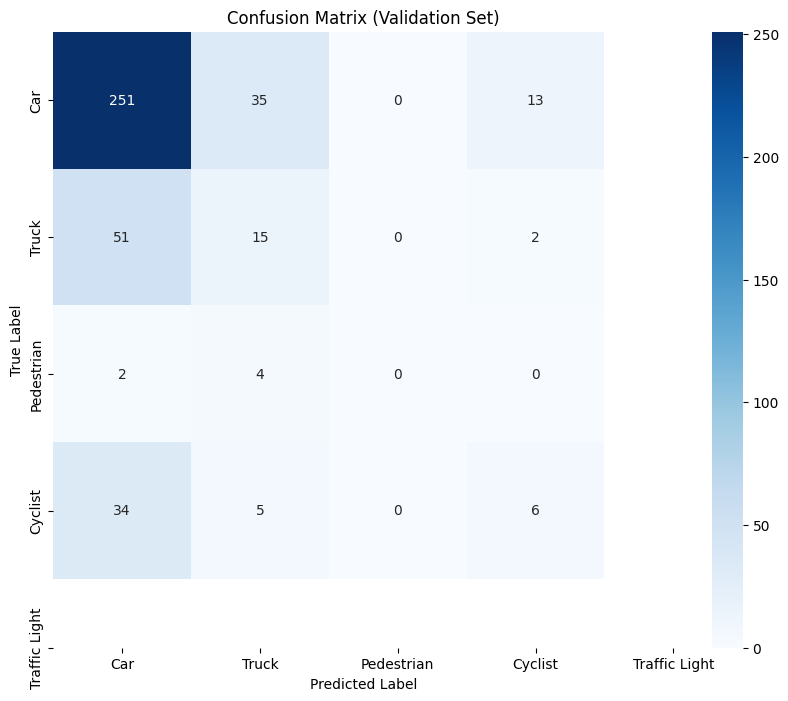

Confusion Matrix saved to /content/drive/MyDrive/YOLOv8_Autonomous_Driving/Results/confusion_matrix.png


In [ ]:
# --- 7. PERFORMANCE VISUALIZATION & METRICS ---
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras_cv

# --- CONFIGURATION ---
# Path to save the generated graphs
GRAPH_SAVE_DIR = "/content/drive/MyDrive/YOLOv8_Autonomous_Driving/Results"
os.makedirs(GRAPH_SAVE_DIR, exist_ok=True)

# Path to your saved model (Ensure this is correct)
MODEL_PATH = '/content/drive/MyDrive/yolov8_model_manuel_kayit.keras'

CLASS_NAMES = ['Car', 'Truck', 'Pedestrian', 'Cyclist', 'Traffic Light']
CONFIDENCE_THRESHOLD = 0.5

print(f"Graphs will be saved to: {GRAPH_SAVE_DIR}")

# ---------------------------------------------------------
# PART 1: Training Loss Curve (If history exists)
# ---------------------------------------------------------
if 'history' in locals():
    print("Training history found. Plotting Loss Curve...")

    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Model Training Performance', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Save plot
    save_path = os.path.join(GRAPH_SAVE_DIR, "training_loss_curve.png")
    plt.savefig(save_path)
    plt.show()
    print(f"Loss curve saved to {save_path}")
else:
    print("WARNING: 'history' variable not found (session might have restarted). Skipping Loss Curve.")

# ---------------------------------------------------------
# PART 2: Confusion Matrix (Using Saved Model)
# ---------------------------------------------------------
print("\nGenerating Confusion Matrix from Validation Set...")

# Load the trained model for inference
try:
    loaded_model = tf.keras.models.load_model(
        MODEL_PATH,
        compile=False,
        custom_objects={
            "YOLOV8Detector": keras_cv.models.YOLOV8Detector,
            "YOLOV8Backbone": keras_cv.models.YOLOV8Backbone
        }
    )
    print("Model loaded successfully.")
except:
    print(f"Error: Could not load model at {MODEL_PATH}. Check the path.")
    raise

y_true_all = []
y_pred_all = []

print("Running inference on validation batches (Sub-sampling)...")

# Take a subset of validation data (e.g., 20 batches) to save time
for batch in val_ds.take(20):
    images = batch['images']
    true_classes = batch['bounding_boxes']['classes']

    # Predict
    preds = loaded_model.predict(images, verbose=0)
    pred_classes = preds['classes']
    confidence = preds['confidence']

    batch_size = tf.shape(images)[0]

    # Process each image in the batch
    for i in range(batch_size):
        # Get Ground Truth (filtering padding -1)
        t_cls = true_classes[i]
        valid_true = t_cls[t_cls != -1]

        # Get Predictions (filtering by threshold)
        p_cls = pred_classes[i]
        p_conf = confidence[i]
        valid_pred = p_cls[p_conf > CONFIDENCE_THRESHOLD]

        # Simplified Matching Logic for Visualization:
        # Compare class distributions in the image
        if len(valid_true) > 0 and len(valid_pred) > 0:
            min_len = min(len(valid_true), len(valid_pred))
            y_true_all.extend(valid_true[:min_len].numpy())
            y_pred_all.extend(valid_pred[:min_len])

# Plot Matrix
if len(y_true_all) > 0:
    cm = confusion_matrix(y_true_all, y_pred_all)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Validation Set)')

    save_path = os.path.join(GRAPH_SAVE_DIR, "confusion_matrix.png")
    plt.savefig(save_path)
    plt.show()
    print(f"Confusion Matrix saved to {save_path}")
else:
    print("Not enough matches found to generate matrix.")